# Scratch Pad: A symbolic playground for Seq2Seq models

```
what does Henry do? <scratch_pad> search('Henry') -> ['Henry is a School Psychologist'] </scratch_pad> School Psychologist

what is 556 - 301? <scratch_pad> 556 - 301 -> 255 </scratch_pad> 255
```

In [1219]:
from rank_bm25 import BM25Okapi
from src.models_and_transforms.BERT_models import AlphaBERT
from src.models_and_transforms.text_transforms import Numericalise_Transform, Scratch_Pad_Sequence_Policy_Creator_Transform, \
                                                        Rename_Transform, Class_Rebalance_Transform
from src.pipe_datasets import Scratch_Pad_Policy_Dataset
import re
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, GPT2TokenizerFast
from transformers import BertConfig, BertTokenizerFast, BertForMaskedLM
from tokenizers import processors, Tokenizer
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, Callback, seed_everything
import numpy as np
import json
from itertools import compress as mask
import sys
import tqdm
from time import perf_counter 
import random
import copy

from src.ScratchPad import ScratchPadGame, EpisodeUtility
from src.FastMCTS import FastMCTS
from src.FasterMCTS import FasterMCTS
from dotmap import DotMap
import numpy as np
from time import perf_counter

from src.useful_utils import chunks
from src.models_and_transforms.GPT2_models import GPT2_Scratch_Pad_Model
sys.path.insert(0,"src/external_repos/pyfuzz/")

%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Searching function

In [7]:
corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]
tokenized_corpus = [re.findall(r"[\w']+|[.,!?;]", doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

In [8]:
def search(q, n=1):
    return bm25.get_top_n(q.split(), corpus, n=n)

## Using BERT for AlphaZero style learning
The model will be both responsible for state $s$ evaluation into a value $v$ and polilcy $\textbf{p}$

\begin{equation*}
(v,\textbf{p})=f(s|\theta)
\end{equation*}

In [2]:
config = BertConfig()
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')

In [3]:
config.num_attention_heads = 1
config.hidden_size = 10
config.num_hidden_layers = 3
config.intermediate_size = 16
config.n_ctx = 512
config.n_positions = 512
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'

In [9]:
model = AlphaBERT(config, mask_token_id=tokenizer.token_to_id('[MASK]'), 
                  value_token_id=tokenizer.token_to_id('[VALUE]'), 
                  pad_token_id=tokenizer.token_to_id('[PAD]'))

In [13]:
tokens = torch.tensor([i.ids for i in tokenizer.encode_batch(['foo'])], dtype=torch.long)
print("Input tokens: "+ str(tokens))
model(tokens)[0].shape

Input tokens: tensor([[77, 86, 86]])


torch.Size([1, 270])

In [6]:
batch = {'input_ids':tokens, 
         'target_policy':torch.tensor([[33409]]), 
#          'target_value':torch.tensor([[1.0]]),
         'attention_mask':torch.ones_like(tokens)}

In [9]:
model.training_step(batch,0)

{'loss': tensor(10.0868, grad_fn=<AddBackward0>),
 'log': {'train_loss': tensor(10.0868, grad_fn=<AddBackward0>)}}

## Monte Carlos Tree Search and simulation

In [173]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
SPGame = ScratchPadGame(tokenizer)
config = BertConfig()
config.num_attention_heads = 1
config.hidden_size = 10
config.num_hidden_layers = 3
config.intermediate_size = 32
config.n_ctx = 512
config.n_positions = 512
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = AlphaBERT(config, mask_token_id=tokenizer.token_to_id('[MASK]'), 
                  value_token_id=tokenizer.token_to_id('[VALUE]'), 
                  pad_token_id=tokenizer.token_to_id('[PAD]'))

args = {'num_episodes':3,
        'num_sims_per_turn':10,
        'policy_exploration_weight':0.5}

In [15]:
explorer = EpisodeUtility(SPGame, **args)

In [11]:
explored_examples = explorer.explore(model)

Exploring env: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

Performed 3 episodes in 3.31s. 0 positive
------------------
What is 3+4?7[EOS]
What is 3+4? Moines polymorphTHER Butter Moinesxffxff Moinesowskixff136OH
Top 3 next actions: ['ennial', ' irony', ' borrowed']
Current reward: -1

What is 2+3?5[EOS]
What is 2+3? borrowed Moines Moines Moinesowski136136 partic thwarted places polymorph MoinesWould irony
Top 3 next actions: [' Moines', ' Acceler', ' polymorph']
Current reward: -1



In [15]:
ideal_answer = "What is 3+4?<ScratchPad>3+4>>>7\n</ScratchPad>7[EOS]"
target = "What is 3+4?7[EOS]"
ideal_canon_state = SPGame.toCanonical(ideal_answer, target)
print(ideal_canon_state)
custom_examples = explorer.decomposePositiveEpisode(ideal_canon_state)
print(custom_examples[4])

{'current_state': tensor([ 2061,   318,   513,    10,    19,    30, 50260,    18,    10,    19,
        33409,    22, 50259, 50261,    22, 50257]), 'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])}
{'canonical_state': {'current_state': tensor([2061,  318,  513,   10]), 'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])}, 'pi': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'id': 'custom', 'reward': 1}


In [16]:
train_samples = copy.deepcopy(custom_examples)
train_samples = explorer.prepExamplesForModel_Transform(train_samples)
train_samples[0]

{'canonical_state': {'current_state': tensor([], dtype=torch.int64),
  'target_state': tensor([ 2061,   318,   513,    10,    19,    30,    22, 50257])},
 'pi': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'id': 'custom',
 'reward': 1,
 'input_ids': tensor([[50263, 50262]])}

In [17]:
train_samples = Class_Rebalance_Transform(field='reward')(train_samples)

In [18]:
train_samples = Rename_Transform(fields=[('pi','target_policy'),('reward','target_value')])(train_samples)

In [19]:
train_dataset = Scratch_Pad_Policy_Dataset(train_samples, slow_pipe=[], real_time_pipe=[])

In [20]:
train_dataloader = train_dataset.to_dataloader(2, shuffle=True)
batch = next(iter(train_dataloader))
batch

{'input_ids': tensor([[ 2061,   318,   513,    10,    19,    30, 50260,    18,    10,    19,
          33409,    22, 50259, 50261,    22, 50263, 50262],
         [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  2061, 50263, 50262]]),
 'attention_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]]),
 'target_policy': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'target_value': tensor([1., 1.])}

In [21]:
batch['target_policy'][0].argmax()

tensor(50257)

In [22]:
trainer = Trainer(gpus=1, gradient_clip_val=1.0, amp_level='O1')
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name        | Type      | Params
------------------------------------------
0 | BERT        | BertModel | 542 K 
1 | dropout     | Dropout   | 0     
2 | value_layer | Linear    | 11    
3 | LM_layer    | Linear    | 552 K 
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [88]:
policy_logit = torch.tensor([[0.03, 0.4, -2, 0.9],
                             [0.1,  0.2, 0.6, -3]])
target = torch.tensor([1, 3])
one_hot_target = torch.tensor([[0,1.0,0,0],
                               [0,0,0,1.0]])

In [89]:
nn.CrossEntropyLoss()(policy_logit.view(-1,4), target.view(-1))

tensor(2.8337)

In [90]:
-torch.dot(one_hot_target.view(-1)**1, torch.log(policy_logit.softmax(-1)).view(-1))/policy_logit.shape[0]

tensor(2.8337)

In [23]:
batch_idx = 0
print(batch['target_policy'][batch_idx].argmax())
model.eval()
model.predict(torch.tensor([[2061,   318]]))[0][batch_idx].argsort(descending=True)[:10]

tensor(50257)


tensor([  513,  2061,    19,   318,    10,    18, 50261, 50257,    22, 50260])

## Creating prompts and answers

In [388]:
def customPromptsAndAnswers(prompt_type, n=100):
    '''
    Generate n prompt-answer pairs of type prompt_type.
    prompt_type: str: 'simple_addition'
    
    returns: [(str: prompt string, str: prompt and answer string)]
    '''
    if prompt_type == 'simple_addition':
        pairs = []
        for i in range(n):
            a = random.randrange(0,30)
            b = random.randrange(0,30)
            prompt = f'What is {a}+{b}?'
            target = f'What is {a}+{b}?{a+b}[EOS]'
            pairs.append((prompt, target))
        return pairs
    if prompt_type == 'simple_addition_with_answer_level_0':
        pairs = []
        for i in range(n):
            a = random.randrange(0,30)
            b = random.randrange(0,30)
            prompt = f'What is {a}+{b}?[SP]{a}+{b}>>>{a+b}\n[ESP]'
            target = f'What is {a}+{b}?{a+b}[EOS]'
            pairs.append((prompt, target))
        return pairs
    else:
        raise f'{prompt_type} not recognised'

In [389]:
customPromptsAndAnswers('simple_addition_with_answer_level_0', 4)

[('What is 25+18?[SP]25+18>>>43\n[ESP]', 'What is 25+18?43[EOS]'),
 ('What is 15+10?[SP]15+10>>>25\n[ESP]', 'What is 15+10?25[EOS]'),
 ('What is 25+14?[SP]25+14>>>39\n[ESP]', 'What is 25+14?39[EOS]'),
 ('What is 4+15?[SP]4+15>>>19\n[ESP]', 'What is 4+15?19[EOS]')]

In [390]:
custom_positive_pairs = [('What is 3+4?[SP]3+4>>>7\n[ESP]7[EOS]', 'What is 3+4?7[EOS]'),
                         ('What is 17+5?[SP]17+5>>>22\n[ESP]22[EOS]', 'What is 17+5?22[EOS]'),
                         ('What is 22+1?[SP]22+1>>>23\n[ESP]23[EOS]', 'What is 22+1?23[EOS]')]

In [385]:
prompt_and_answers = customPromptsAndAnswers('simple_addition_with_answer_level_0', 200)
SPGame = ScratchPadGame(tokenizer, prompt_target_pairs=prompt_and_answers, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}
episode_utility = EpisodeUtility(SPGame, **args)

custom_positive_examples = []
for prompt, ideal_target in custom_positive_pairs:
    custom_positive_examples += episode_utility.decomposePositiveEpisode((SPGame.toCanonical(prompt, ideal_target)))
custom_positive_examples = Rename_Transform(fields=[('pi','target_policy'),('reward','target_value')])(custom_positive_examples)

NameError: name 'stmnt_out' is not defined

In [380]:
episode_utility.fullLoopTrainer(model, custom_examples=custom_positive_examples, max_epochs=100)

ValueError: max() arg is an empty sequence

In [33]:
exs = episode_utility.explore(model)

Exploring env: 100%|██████████| 1000/1000 [01:17<00:00, 12.83it/s]

Performed 1000 episodes in 77.96s. 0 positive
------------------
What is 3+3?6[EOS]
What is 3+3?<ScratchPad>3+3>>>6
</ScratchPad> Somehow Exclusive
Top 3 next actions: [' Hercules', ' Exclusive', ' UPS']
Current reward: -1

What is 6+2?8[EOS]
What is 6+2?<ScratchPad>6+2>>>8
</ScratchPad>lb
Top 3 next actions: [' comprehensive', 'lb', ' driveway']
Current reward: -1



## Performance profiling

In [124]:
custom_positive_examples[0]['canonical_state']['input_ids']

tensor([[50263, 50262]])

In [271]:
a = torch.tensor([[1,2,3],[4,5,6]])
a[torch.tensor([0,1]), torch.tensor([1,2])] = torch.tensor([8,9])
a

tensor([[1, 8, 3],
        [4, 5, 9]])

In [8]:
current_states = torch.nn.utils.rnn.pad_sequence([sample['canonical_state']["input_ids"].flip(1)[0] for sample in custom_positive_examples[:3]], 
                                                 padding_value=50258, batch_first=True).flip(1)
target_strings = [sample['canonical_state']["string_rep"] for sample in custom_positive_examples[:3]]

KeyError: 'input_ids'

In [8]:
current_states = torch.tensor(tokenizer.encode('What is 3+4?').ids, dtype=torch.long, device='cpu').unsqueeze(0)

In [9]:
current_states.shape

torch.Size([1, 7])

In [10]:
target_strings = ['What is 3+4?7[EOS]']

In [11]:
_ = model.eval()
_ = model.to("cpu")

In [375]:
sorted(list(faster_MCTS.cache.items()), key=lambda s: s[1]['N'], reverse=True)[:10]

[('What is 3+4?',
  {'state': tensor([268, 267, 228,  26,  18,  27,  38]),
   'N': tensor([1161.]),
   'Qa': tensor(indices=tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
                            11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
                            22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
                            33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
                            44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
                            55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
                            66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
                            77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
                            88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                            99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                           110, 111, 112, 113, 114, 115, 116, 117, 118, 11

In [174]:
faster_MCTS = FasterMCTS(SPGame, model)
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

visited


tensor([-0.1727])

In [374]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
                         11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
                         22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
                         33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
                         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
                         55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
                         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
                         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
                         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
                        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
                        132, 133, 134, 135, 136, 137

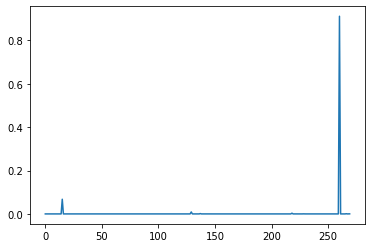

In [381]:
probs = faster_MCTS.getActionProb(current_states, temp=5)
plt.plot(range(270), probs[0])

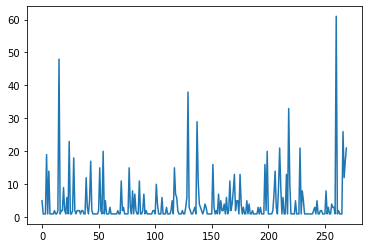

In [355]:
plt.plot(range(270), faster_MCTS.cache['What is 3+4?']['Na'].to_dense())

In [333]:
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

tensor([-0.4327])

In [336]:
for i in range(500):
    faster_MCTS.batchSearch(current_states, target_strings, sample=False)

In [358]:
current_states

tensor([[268, 267, 228,  26,  18,  27,  38]])

In [379]:
tokenizer.decode([228])

' '

In [330]:
faster_MCTS.batchSearch(current_states, target_strings, sample=False)

visited
top nex actions tensor([[108, 201, 117, 163, 106, 156,  54, 206, 138, 150]]) for states tensor([[268, 267, 228,  26,  18,  27,  38]])
selecting action tensor([[108]]) for states tensor([[268, 267, 228,  26,  18,  27,  38]])
visited
top nex actions tensor([[116,  23, 220,  14,  52,  16,  10,  73, 108, 201]]) for states tensor([[268, 267, 228,  26,  18,  27,  38, 108]])
selecting action tensor([[156]]) for states tensor([[268, 267, 228,  26,  18,  27,  38, 108]])
visited
returned_values tensor([-0.4261])
pre Na tensor(indices=tensor([], size=(1, 0)),
       values=tensor([], size=(0,)),
       size=(270,), nnz=0, layout=torch.sparse_coo) for a tensor([156])
post Na tensor(indices=tensor([[156]]),
       values=tensor([1.]),
       size=(270,), nnz=1, layout=torch.sparse_coo) for a tensor([156])
returned_values tensor([-0.4261])
pre Na tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(270,), nnz=

tensor([-0.4261])

In [318]:
%debug

> /nfs/phd_by_carlos/notebooks/src/FasterMCTS.py(118)batchSearch()
    116             self.cache[string_reps[i]]['Qa'] = dense_Qa.to_sparse()
    117 #             print('Qa', self.cache[string_reps[i]]['Qa'], 'for a', a[i])
--> 118 
    119             print('pre Na', self.cache[string_reps[i]]['Na'], 'for a', a[i])
    120             dense_Na[a[i]] += 1



ipdb>  exit


In [302]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 108, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(270,), nnz=9, layout=torch.sparse_coo)

In [304]:
dense_Na = faster_MCTS.cache['What is 3+4?']['Na'].to_dense()
dense_Na[73] += 1
faster_MCTS.cache['What is 3+4?']['Na'] = dense_Na.to_sparse()

In [305]:
faster_MCTS.cache['What is 3+4?']['Na']

tensor(indices=tensor([[ 10,  14,  16,  23,  52,  73, 108, 116, 220]]),
       values=tensor([1., 1., 1., 1., 1., 2., 1., 1., 1.]),
       size=(270,), nnz=9, layout=torch.sparse_coo)

In [12]:
%mprun -f faster_MCTS.batchSearch faster_MCTS.batchSearch(current_states, target_strings)

visited
visited
visited



Filename: /nfs/phd_by_carlos/notebooks/src/FasterMCTS.py

Line #    Mem usage    Increment  Occurences   Line Contents
    43   7647.7 MiB   5228.6 MiB           3       def batchSearch(self, current_states, target_strings, sim_action_select_temp=1, sample=True):
    44                                                 '''
    45                                                 current_states: padded Long tensor: [N, seq_len]
    46                                                 target_states: [str]: [N]
    47                                                 '''
    48   7647.7 MiB      0.0 MiB           3           N = current_states.shape[0]
    49   7647.7 MiB      0.0 MiB           3           vocab_size = self.game.getActionSize()
    50   7647.7 MiB      0.0 MiB           3           string_reps = self.game.batchStringRep(current_states) # [str*N]
    51   7647.7 MiB      0.1 MiB           3           game_states = self.game.batchGameEnded(current_states, target_strings) # torch.te

In [37]:
SPGame.batchGameEnded(current_states, target_strings)

RuntimeError: All input tensors must be on the same device. Received cuda:0 and cpu

## Trying out tokenizers

In [24]:
from tokenizers import ByteLevelBPETokenizer, Tokenizer
tokenizer = ByteLevelBPETokenizer(add_prefix_space=False)

# And then train
tokenizer.train(
    ["datasets/ScratchPad/samples.txt"],
    vocab_size=1000,
    min_frequency=2,
    show_progress=True,
    special_tokens=['[PAD]','[EOS]','[VALUE]','[MASK]','\n','[SP]', '[ESP]','>>>'],
)
tokenizer.enable_padding(direction='left')

tokenizer.save('datasets/ScratchPad/tokenizer_simple.json')
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')

inputs = tokenizer.encode('[VALUE]What is 8+4?[SP]3+4>>>7\n[ESP]7[EOS]')
print(inputs.ids)
print(inputs.tokens)
tokenizer.decode(inputs.ids, skip_special_tokens=False)

[2, 268, 267, 269, 18, 27, 38, 5, 26, 18, 27, 7, 30, 4, 6, 30, 1]
['[VALUE]', 'What', 'Ġis', 'Ġ8', '+', '4', '?', '[SP]', '3', '+', '4', '>>>', '7', '\n', '[ESP]', '7', '[EOS]']


'[VALUE]What is 8+4?[SP]3+4>>>7\n[ESP]7[EOS]'

## Clean Environment

In [967]:
from src.environments import Scratch_Pad_Environment
from src.FasterMCTS import FasterMCTS
from src.RL_trainer import AlphaZero_Trainer

In [1310]:
tokenizer = Tokenizer.from_file('datasets/ScratchPad/tokenizer_simple.json')
env = Scratch_Pad_Environment(tokenizer, device='cpu')

args = {'num_episodes':1000,
        'num_sims_per_turn':2,
        'policy_exploration_weight':0.5}
# trainer = EpisodeUtility(SPGame, **args)


In [1279]:
config = BertConfig()
config.num_attention_heads = 1
config.hidden_size = 10
config.num_hidden_layers = 3
config.intermediate_size = 32
config.n_ctx = 512
config.n_positions = 512
config.temp = 1
config.vocab_size = len(tokenizer.get_vocab())
config.position_embedding_type = 'relative_key_query'
model = AlphaBERT(config, mask_token_id=tokenizer.token_to_id('[MASK]'), 
                  value_token_id=tokenizer.token_to_id('[VALUE]'), 
                  pad_token_id=tokenizer.token_to_id('[PAD]'))

In [1200]:
print(env.strings_to_state(['What is 3+4?[SP]3+4']))
current_states = env.strings_to_state(['What is 3+4?[SP]3+4'])
target_strings = np.array(['What is 3+4?7[EOS]'])
current_states

tensor([[268, 267, 228,  26,  18,  27,  38,   5,  26,  18,  27]])


tensor([[268, 267, 228,  26,  18,  27,  38,   5,  26,  18,  27]])

In [1285]:
_ = model.cuda()
_ = model.eval()

In [1241]:
seed_everything(10)
current_states, target_strings = env.random_states(3, 'simple_addition',seed=10)
current_states, target_strings = current_states, target_strings
print(env.to_hash(current_states))
current_states.shape

10
['What is 18+1?', 'What is 13+15?', 'What is 18+0?']


torch.Size([3, 9])

In [1242]:
mcts = FasterMCTS(model, env)

In [1078]:
forced_trajectory = torch.tensor([[6,  30,   1]])
mcts.search(current_states, target_strings, forced_trajectory=None)[:10]

tensor([0.4950, 0.4951, 0.4952, 0.4949, 0.4953, 0.4952, 0.4956, 0.4952, 0.4952,
        0.4954])

In [1203]:
%lprun -f env.scratchPadMask for i in tqdm.tqdm(range(500)): mcts.search(current_states, target_strings)

  1%|          | 5/500 [00:00<00:12, 39.71it/s]

['What is 3+4?[SP]3+4'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What i

  2%|▏         | 10/500 [00:00<00:18, 25.91it/s]

['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4�������'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4�������'] tensor([False])
['What is 3+4?[SP]3+4��������'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4�������'] tensor([False])
['What is 3+4?[SP]3+4��������'] tensor([False])
['What is 3+4?[SP]3+4'] tens

  3%|▎         | 14/500 [00:00<00:23, 20.63it/s]

['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4������\t'] tensor([False])
['What is 3+4?[SP]3+4������\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4������\t'] tensor([False])
['What is 3+4?[SP]3+4������\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] t

  4%|▎         | 18/500 [00:00<00:25, 18.95it/s]

['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4������'] tensor([False])
['What is 3+4?[SP]3+4�������'] tensor([False])
['What is 3+4?[SP]3+4�������\t'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4�����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4�����\t'] tensor([False])
['What is 3+4?[SP]3+4�����\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([Fals

  4%|▍         | 20/500 [00:00<00:26, 18.38it/s]

['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4�����\t'] tensor([False])
['What is 3+4?[SP]3+4�����\t�'] tensor([False])
['What is 3+4?[SP]3+4�����\t��'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4�����\t'] tensor([False])
['What is 3+4?[SP]3+4�����\t\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4�����'] tensor([False])
['What is 3+4?[SP]3+4�����\t'] tensor([False])
['What is 3+4?[SP]3+4�����\t\t

  5%|▌         | 25/500 [00:01<00:26, 18.09it/s]

['What is 3+4?[SP]3+4�����\t\t'] tensor([False])
['What is 3+4?[SP]3+4�����\t\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t��'] tensor([T

  5%|▌         | 27/500 [00:01<00:27, 17.33it/s]

['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t��'] tensor([False])
['What is 3+4?[SP]3+4����\t���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t��'] tensor([False])
['What is 3+4?[SP]3+4����\t���'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t�\t'] tensor([True])
['What is 3+4?[S

  6%|▌         | 31/500 [00:01<00:27, 17.24it/s]

['What is 3+4?[SP]3+4����\t�\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t�\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4����'] tensor([False])
['What is 3+4?[SP]3+4����\t'] tensor([False])
['What is 3+4?[SP]3+4����\t�'] tensor([False])
['What is 3+4?[SP]3+4����\t��'] tensor([False])
['What is 3+4?[SP]3+4����\t��\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3

  7%|▋         | 36/500 [00:01<00:24, 19.07it/s]

['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?[SP]3+4���\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?

  8%|▊         | 40/500 [00:02<00:25, 17.97it/s]

['What is 3+4?[SP]3+4���\t��'] tensor([False])
['What is 3+4?[SP]3+4���\t���'] tensor([False])
['What is 3+4?[SP]3+4���\t����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?[SP]3+4���\t��'] tensor([False])
['What is 3+4?[SP]3+4���\t���'] tensor([False])
['What is 3+4?[SP]3+4���\t����'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?[SP]3+4���\t��'] tensor([False])
['What is 3+4?[SP]3+4���\t��\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��

  8%|▊         | 42/500 [00:02<00:25, 17.71it/s]

tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?[SP]3+4���\t��'] tensor([False])
['What is 3+4?[SP]3+4���\t��\t'] tensor([False])
['What is 3+4?[SP]3+4���\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['What is 3+4?[SP]3+4���\t��'] tensor([False])
['What is 3+4?[SP]3+4���\t���'] tensor([False])
['What is 3+4?[SP]3+4���\t���\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4���'] tensor([False])
['What is 3+4?[SP]3+4���\t'] tensor([False])
['What is 3+4?[SP]3+4���\t�'] tensor([False])
['Wh

 10%|▉         | 48/500 [00:02<00:22, 19.98it/s]

['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[S

 10%|█         | 51/500 [00:02<00:24, 18.38it/s]

['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([False])
['What is 3+4?[SP]3+4��\t����'] tensor([False])
['What is 3+4?[SP]3+4��\t�����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([False])
['What is 3+4?[SP]3+4��\t����'] tensor([False])
['What is 3+4?[SP]3+4��\t�����'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([False])
['What is 3+4?[

 11%|█         | 55/500 [00:02<00:25, 17.57it/s]

['What is 3+4?[SP]3+4��\t���\t'] tensor([False])
['What is 3+4?[SP]3+4��\t���\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([False])
['What is 3+4?[SP]3+4��\t���\t'] tensor([False])
['What is 3+4?[SP]3+4��\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4��'] tensor([False])
['What is 3+4?[SP]3+4��\t'] tensor([False])
['What is 3+4?[SP]3+4��\t�'] tensor([False])
['What is 3+4?[SP]3+4��\t��'] tensor([False])
['What is 3+4?[SP]3+4��\t���'] tensor([False])
['What is 3+4?[SP]3+4��\t����'] tensor([False])
['What is 3+4?[SP]3+4��\t����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[

 12%|█▏        | 59/500 [00:02<00:21, 20.45it/s]

['What is 3+4?[SP]3+4�\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([True])
['What is 3+4?[S

 12%|█▏        | 62/500 [00:03<00:23, 19.01it/s]

['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t�����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t�����'] tensor([False])
['What is 3+4?[SP]3+4�\t������'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t�����'] tensor([False])
['What is 3+4?[SP]3+4�\t������'] tensor([False])
['What is 

 13%|█▎        | 67/500 [00:03<00:25, 17.21it/s]

['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t����\t'] tensor([False])
['What is 3+4?[SP]3+4�\t����\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t����\t'] tensor([False])
['What is 3+4?[SP]3+4�\t����\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[

 14%|█▍        | 71/500 [00:03<00:21, 20.28it/s]

['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t����'] tensor([False])
['What is 3+4?[SP]3+4�\t�����'] tensor([False])
['What is 3+4?[SP]3+4�\t�����\t'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([True])
['What is 

 15%|█▌        | 77/500 [00:03<00:20, 20.17it/s]

['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([False])
['What is 3+4?[SP]3+4\t������'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([False])
['What is 3+4?[SP]3+4\t������'] tensor([False])
['What is 3+4?[SP]3+4\t�������'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\

 16%|█▌        | 80/500 [00:04<00:21, 19.31it/s]

['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([False])
['What is 3+4?[SP]3+4\t�����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([False])
['What is 3+4?[SP]3+4\t�����\t'] tensor([False])
['What is 3+4?[SP]3+4\t�����\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+

 17%|█▋        | 83/500 [00:04<00:21, 18.99it/s]

['What is 3+4?[SP]3+4\t������\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t�����'] tensor([False])
['What is 3+4?[SP]3+4\t������'] tensor([False])
['What is 3+4?[SP]3+4\t������\t'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t����\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t��

 17%|█▋        | 87/500 [00:04<00:22, 18.59it/s]

['What is 3+4?[SP]3+4\t����\t�'] tensor([False])
['What is 3+4?[SP]3+4\t����\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t����\t'] tensor([False])
['What is 3+4?[SP]3+4\t����\t�'] tensor([False])
['What is 3+4?[SP]3+4\t����\t��'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t����\t'] tensor([False])
['What is 3+4?[SP]3+4\t����\t\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4

 18%|█▊        | 92/500 [00:04<00:21, 19.40it/s]

['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t����'] tensor([False])
['What is 3+4?[SP]3+4\t����\t'] tensor([False])
['What is 3+4?[SP]3+4\t����\t\t'] tensor([False])
['What is 3+4?[SP]3+4\t����\t\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t���\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t���\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t

 19%|█▉        | 96/500 [00:04<00:21, 18.53it/s]

['What is 3+4?[SP]3+4\t���\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4\t���\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���\t���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t���\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4\t���\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���\t���'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t���\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
[

 20%|█▉        | 98/500 [00:05<00:21, 18.48it/s]

['What is 3+4?[SP]3+4\t'] tensor([False])
['What is 3+4?[SP]3+4\t�'] tensor([False])
['What is 3+4?[SP]3+4\t��'] tensor([False])
['What is 3+4?[SP]3+4\t���'] tensor([False])
['What is 3+4?[SP]3+4\t���\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�\t'] tensor([False])
['What is 3+4?[SP]3+4\t���\t�\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t'] tensor([False])
['What is 3+4?[SP

 20%|██        | 102/500 [00:05<00:22, 17.70it/s]

['What is 3+4?[SP]3+4�\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t��'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[S

 21%|██        | 106/500 [00:05<00:22, 17.18it/s]

['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t���'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t\t'] tensor([False])
['What is 3+4?[SP]3+4�\t���\t\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] t

 22%|██▏       | 108/500 [00:05<00:24, 16.30it/s]

['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t��'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t���'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t���'] tensor([False])

 23%|██▎       | 113/500 [00:05<00:20, 18.97it/s]

['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�\t'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�\t�'] tensor([True])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['What is 3+4?[SP]3+4�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�\t'] tensor([False])
['What is 3+4?[SP]3+4�\t��\t�\t�'] tensor([False])
['What is 3+4?[SP]3+4'] tensor([False])
['What is 3+4?[SP]3+4�'] tensor([False])
['Wha

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-06 s

Total time: 0.115841 s
File: /nfs/phd_by_carlos/notebooks/src/environments.py
Function: scratchPadMask at line 69

Line #      Hits         Time  Per Hit   % Time  Line Contents
    69                                               def scratchPadMask(self, current_states):
    70      1572       2171.0      1.4      1.9          N = current_states.shape[0]
    71      1572      14999.0      9.5     12.9          is_SP_start_tok = current_states == self.SP_id
    72      1572       7692.0      4.9      6.6          is_SP_end_tok = current_states == self.ESP_id
    73      1572      37580.0     23.9     32.4          is_SP_end_tok = torch.cat((torch.tensor([[False]]*N, device=self.device), is_SP_end_tok[:,:-1]), dim=1)
    74                                                   
    75      1572       9769.0      6.2      8.4          SP_toks = is_SP_start_tok + is_SP_end_tok
    76      1572      42739.0     27.2     36.9          SP_mask = torch.cumsum(SP_toks.to(torch

In [1039]:
sorted(list(mcts.cache.items()), key=lambda s: s[1]['N'], reverse=True)[:10]

[('What is 3+4?[SP]3+4',
  {'state': tensor([  0,   0,   0,   0,   0,   0,   0, 268, 267, 228,  26,  18,  27,  38,
             5,  26,  18,  27]),
   'N': tensor([3.]),
   'Qa': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [ ]:
trainer = AlphaZero_Trainer(model, env)
examples = trainer.execute_episodes(episodes=250, simulations=1600,seed=10, problem_type='simple_addition_with_answer_level_0')

Sims for 250 episodes:   0%|          | 0/1600 [00:00<?, ?it/s]

For 250 episodes found 250 unique.


Sims for 124 episodes:   0%|          | 2/1600 [00:00<02:24, 11.08it/s]

126 terminated, 124 left.


Sims for 25 episodes:   0%|          | 3/1600 [00:00<00:58, 27.50it/s]

99 terminated, 25 left.


Sims for 25 episodes:  49%|████▉     | 788/1600 [00:25<00:26, 31.13it/s]

In [1309]:
positive_strings = ['What is 3+4?[SP]3+4>>>7\n[ESP]7[EOS]',
                    'What is 17+5?[SP]17+5>>>22\n[ESP]22[EOS]',
                    'What is 22+1?[SP]22+1>>>23\n[ESP]23[EOS]']
target_strings = ['What is 3+4?7[EOS]',
                    'What is 17+5?22[EOS]',
                    'What is 22+1?23[EOS]']
positive_states = env.strings_to_state(positive_strings)

In [1318]:
trainer.decomposePositiveEpisodes(positive_states, target_strings)

[{'current_state': tensor([], dtype=torch.int64),
  'target_string': 'What is 3+4?7[EOS]',
  'pi': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 